In [4]:
import numpy as np
from ripser import Rips, ripser
import matplotlib.pyplot as plt
from get_hdmatrices import TARG

import pandas as pd

## Data Preprocessing

In [5]:
# params = {
#     "SAMPLES": 10,
#     "SIMULATIONS": 5,
#     "GROUPS": 1,
#     "SEGSITES": 100,
#     "FNAME": "sim_50_72.txt"
# }

params = {
    "SAMPLES": 60, # no. of lines/chromosomes per sim
    "SIMULATIONS": 5, # no. of sim per file
    "GROUPS": 1, # no. of files
    "SEGSITES": 300,
    "FNAME": "sims_200_72.txt"
}

targ = TARG(samples=params["SAMPLES"],
            simulations=params["SIMULATIONS"],
            groups=params["GROUPS"],
            segsites=params["SEGSITES"],
            maxdim=2 #max dimension for homology computations
            )

# File Processing
# (SIMULATIONS, SAMPLES)
group = targ.get_sample_sequences(params["FNAME"])

# Hamming Distance Matrix Computation
# (SIMULATIONS, SAMPLES, SAMPLES)
hdmatrices = targ.get_hdmatrices(group)

# Add Stochasticity Computation
# (SIMULATIONS, VARIANCES, SAMPLES, SAMPLES)
stochmatrices = targ.add_stochasticity(hdmatrices)
var_values = np.around(np.linspace(0, 2, 21), decimals=2)


# Sparsity Sampling
sparse_samples = targ.get_sparse_samples(group) # output is list of sequences
sparse_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

In [6]:
# Process Sparse Samples into Hamming Distance Matrices

# Initialize a new list to store the Hamming distance matrices
sparse_hdmats = []

for sim_idx in range(targ.SIMULATIONS):
    sim_matrices = []  # List to hold matrices for all sampling ratios within a simulation
    
    sequences = sparse_samples[sim_idx]  # Get the sequences at this sampling ratio
    hdmats = targ.get_hdmatrices(sequences)  # Compute the Hamming distance matrix
    
    sparse_hdmats.append(hdmats)  # Append the list of matrices for this simulation to the main list


In [19]:
sparse_hdmats

[[array([[  0.,  68.,  66.,  91.,  46.,  96.],
         [ 68.,   0.,  66.,  99.,  86.,  78.],
         [ 66.,  66.,   0.,  95., 100.,  90.],
         [ 91.,  99.,  95.,   0.,  73.,  75.],
         [ 46.,  86., 100.,  73.,   0.,  90.],
         [ 96.,  78.,  90.,  75.,  90.,   0.]]),
  array([[  0.,  17.,  68.,  92.,  47.,  87., 104.,  56.,  67.,  82.,  48.,
           63.],
         [ 17.,   0.,  59.,  81.,  60.,  80.,  99.,  49.,  80.,  67.,  55.,
           48.],
         [ 68.,  59.,   0.,  98.,  85.,  53.,  80.,  64.,  75.,  80.,  90.,
           57.],
         [ 92.,  81.,  98.,   0.,  67.,  93.,  94.,  86., 103.,  32., 100.,
           87.],
         [ 47.,  60.,  85.,  67.,   0.,  82., 103.,  61.,  76.,  75.,  53.,
           76.],
         [ 87.,  80.,  53.,  93.,  82.,   0.,  47.,  79.,  46.,  89.,  73.,
           76.],
         [104.,  99.,  80.,  94., 103.,  47.,   0., 100.,  81.,  86.,  92.,
           95.],
         [ 56.,  49.,  64.,  86.,  61.,  79., 100.,   0.,  63.,  

In [20]:
# Get the HD matrix from the 1st simulation, where variance = 0.0
# print(stochmatrices[0][2])
# len(stochmatrices)

len(stochmatrices[0]) # sim 1: all 21 variances
len(stochmatrices[0][0]) # sim 1: var=0

# len(hdmatrices)

60

## Topological Quantities


### Persistence Diagram

Homologies      contains a list of three entries
                each entry is a record of birth and death times
                of each homology group ($H_0, H_1, H_2$)

In [7]:
rips = Rips(maxdim=targ.MAXDIM, do_cocycles=True)

# Show the persistence diagram
homologies1 = []

# TODO: Fix to get all simulations, currently only gets the 1st simulation
# GOAL: homologies of dimension (STOCHMATRICES, SIMULATIONS, MAXDIM+1, X)
for sim in stochmatrices:
    homologies1.append(rips.fit_transform(sim[0], distance_matrix=True))

# For testing purposes only
# hom1 = homologies1[0]
# rips.plot(hom1, show=True)

len(homologies1)

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=True, n_perm = None, verbose=True)


5

# Varying error variance

### Setting up the homology lists
We take homology lists of Hamming Distance matrices at increasing variance of the error matrix

In [9]:
def get_homologies(hdlist):
        rips = Rips(maxdim=targ.MAXDIM, do_cocycles=True)

        homologies = []
        for sim in hdlist:
            hom_grps = []

            for i in range(len(sim)):
                hom_grps.append(rips.fit_transform(sim[i], distance_matrix=True))

            homologies.append(hom_grps)

        return homologies

varshom = get_homologies(stochmatrices)

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=True, n_perm = None, verbose=True)


### Plot the persistence diagrams matrix

In [ ]:
fig, axs = plt.subplots(nrows=21, ncols=5, figsize=(25,105))
# rips.plot(hom[0][0], show=True)

# Loop over the range of variances and simulations
for var in range(len(var_values)):  # Loop over the variances
    for sim in range(targ.SIMULATIONS):  # Loop over the simulations
        rips.plot(varshom[sim][var], ax=axs[var, sim], show=False)  # Plot each hom[j][i] on the corresponding subplot


### Process output into lists over all simulations

In [11]:
def get_topostats(targ, homologies):
    # NOTE: homologies = [SIMULATIONS][VARS/SPARSITY]

    BETTIS = []
    MEAN_BARCODE_LENGTHS = []
    VAR_BARCODE_LENGTHS = []

    for sim_idx in range(len(homologies)):
        bettis_persim = []
        meanlens_persim = []
        varlens_persim = []

        for i in range(len(homologies[sim_idx])):
            hom_grps = homologies[sim_idx][i] # Get homologies for this simulation and variance

            # Bettis
            betti_numbers = targ.get_betti_numbers(hom_grps)
            bettis_persim.append (betti_numbers)

            # Compute barcode lengths
            barcode_lens = targ.get_barcode_lengths(hom_grps)

            # mean lengths and variance
            mean_len, var_len = targ.get_barcode_length_statistics(barcode_lens)
            meanlens_persim.append(mean_len)
            varlens_persim.append(var_len)

        # Append results per sim
        BETTIS.append(bettis_persim)
        MEAN_BARCODE_LENGTHS.append(meanlens_persim)
        VAR_BARCODE_LENGTHS.append(varlens_persim)

    return BETTIS, MEAN_BARCODE_LENGTHS, VAR_BARCODE_LENGTHS


In [19]:
BETTIS_V, MEAN_BARCODE_LENGTHS_V, VAR_BARCODE_LENGTHS_V = get_topostats(targ, varshom)


21

### The Line Plots

In [13]:
# Define colors for each homology dimension
colors = {
    0: '#013366',  # H0
    1: '#ea7334', # H1
    2: '#008b8b'    # H2
}

In [ ]:
def add_trend_line_with_ci(ax, x, y, color, alpha=0.3):
    # Calculate the mean and standard deviation
    mean_y = np.mean(y, axis=0)
    std_y = np.std(y, axis=0)
    ci = 1.96 * (std_y / np.sqrt(len(y)))  # 95% confidence interval

    # Fit a polynomial of degree 1 (linear trend) to the data
    coefficients = np.polyfit(x, mean_y, 1)
    polynomial = np.poly1d(coefficients)
    trend_line = polynomial(x)

    # Plot the trend line
    ax.plot(x, trend_line, color=color, linestyle='-', linewidth=2)

    # Plot the confidence interval
    ax.fill_between(x, trend_line - ci, trend_line + ci, color=color, alpha=alpha)

In [23]:
def plot_lines(ax, targ, LIST, values, xlab, ylab, main):
    
    colors = {
        0: '#013366',  # H0
        1: '#ea7334', # H1
        2: '#008b8b'    # H2
    }


    for dim in range(targ.MAXDIM+1):  # H0, H1, H2
        all_sims = []
        for sim_idx in range(len(LIST)):
            y = [LIST[sim_idx][i][dim] for i in range(len(values))]
            ax.plot(values, y, color=colors[dim], alpha=0.4, linestyle='-', marker='o')
            all_sims.append(y)
        
        # Calculate the mean and confidence interval for the trend line
        add_trend_line_with_ci(ax, values, np.array(all_sims), colors[dim])
        
        # Add a legend entry for each homology dimension
        ax.plot([], [], color=colors[dim], label=f'H{dim}')
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(main)



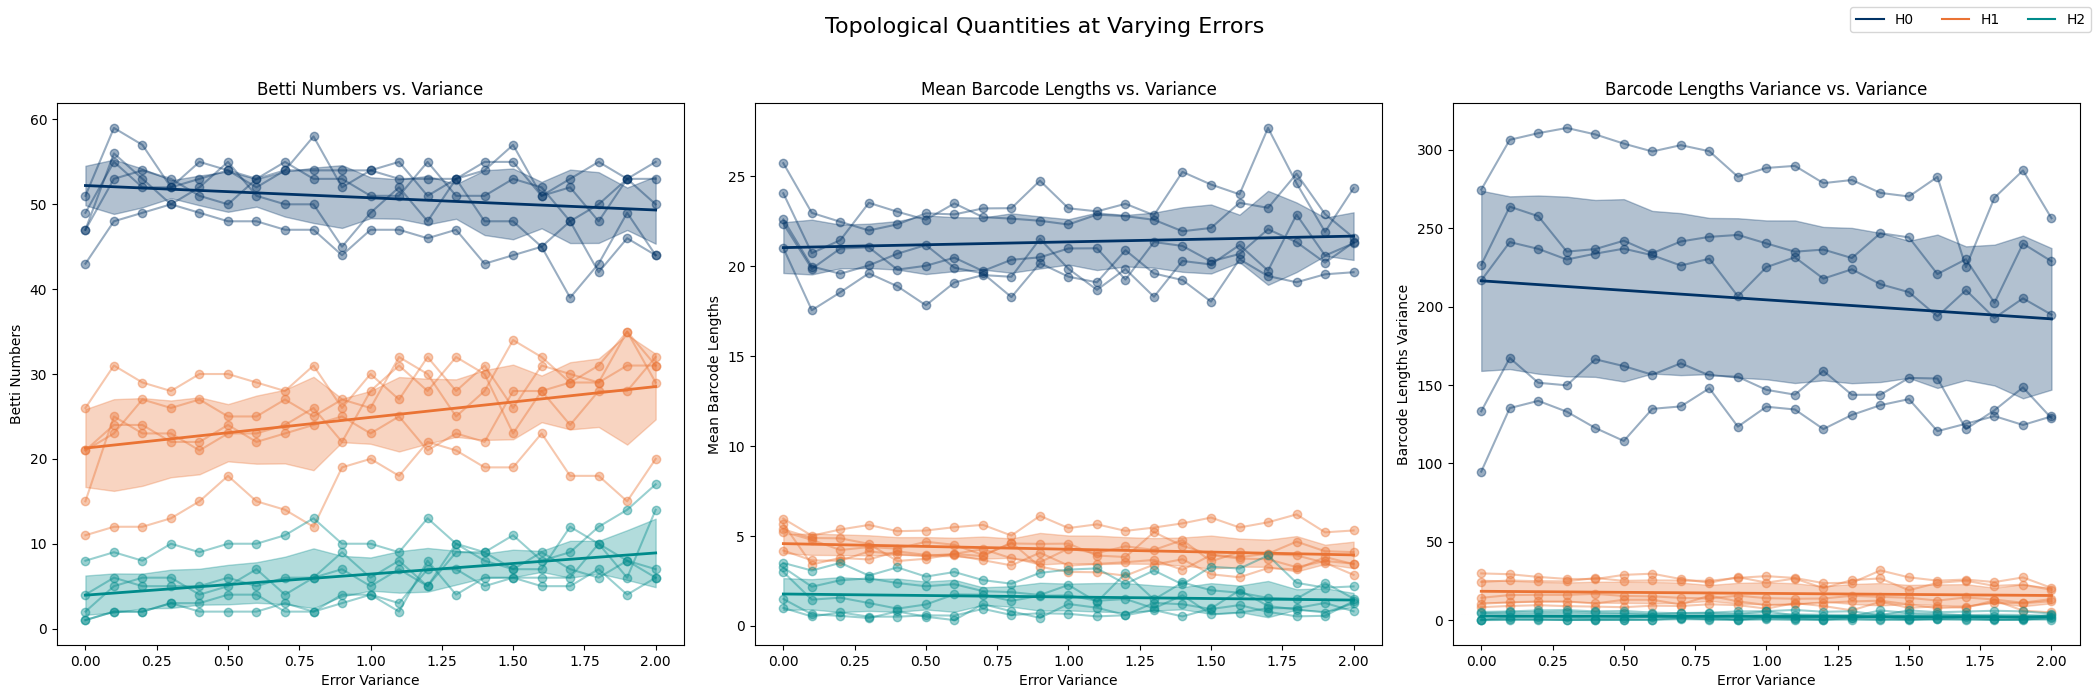

In [25]:
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(21, 7))  # 1 row, 3 columns

# Plot the results in subplots
plot_lines(axs[0], targ, BETTIS_V, var_values, xlab='Error Variance', ylab='Betti Numbers', main='Betti Numbers vs. Variance')
plot_lines(axs[1], targ, MEAN_BARCODE_LENGTHS_V, var_values, xlab='Error Variance', ylab='Mean Barcode Lengths', main='Mean Barcode Lengths vs. Variance')
plot_lines(axs[2], targ, VAR_BARCODE_LENGTHS_V, var_values, xlab='Error Variance', ylab='Barcode Lengths Variance', main='Barcode Lengths Variance vs. Variance')

# Add a main title for the entire figure
fig.suptitle('Topological Quantities at Varying Errors', fontsize=16)

# Create a single legend for the entire figure
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=3)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title
plt.show()

### Display and save as data frames

In [ ]:
# Create DataFrames from the results

# For Betti Numbers
betti_rows = []
for sim_idx in range(params["SIMULATIONS"]):
    for var_idx in range(len(var_values)):
        betti_rows.append({
            "Simulation": sim_idx,
            "Variance": round(var_idx * 0.1, 2),  # Variances are 0, 0.1, 0.2, ..., 2.0
            "H0": BETTIS[sim_idx][var_idx][0],
            "H1": BETTIS[sim_idx][var_idx][1],
            "H2": BETTIS[sim_idx][var_idx][2]
        })

# Convert the list of dictionaries to a DataFrame
betti_df = pd.DataFrame(betti_rows)


# For Average Barcode Lengths
avg_lengths_rows = []
for sim_idx in range(params["SIMULATIONS"]):
    for var_idx in range(len(var_values)):
        avg_lengths_rows.append({
            "Simulation": sim_idx,
            "Variance": round(var_idx * 0.1, 2),  # Variances are 0, 0.1, 0.2, ..., 2.0
            "Avg_H0": AVG_BARCODE_LENGTHS[sim_idx][var_idx][0],
            "Avg_H1": AVG_BARCODE_LENGTHS[sim_idx][var_idx][1],
            "Avg_H2": AVG_BARCODE_LENGTHS[sim_idx][var_idx][2]
        })

# Convert the list of dictionaries to a DataFrame
avg_lengths_df = pd.DataFrame(avg_lengths_rows)

# For Variance of Barcode Lengths
var_lengths_rows = []
for sim_idx in range(params["SIMULATIONS"]):
    for var_idx in range(len(var_values)):
        var_lengths_rows.append({
            "Simulation": sim_idx,
            "Variance": round(var_idx * 0.1, 2),  # Variances are 0, 0.1, 0.2, ..., 2.0
            "Var_H0": VAR_BARCODE_LENGTHS[sim_idx][var_idx][0],
            "Var_H1": VAR_BARCODE_LENGTHS[sim_idx][var_idx][1],
            "Var_H2": VAR_BARCODE_LENGTHS[sim_idx][var_idx][2]
        })

# Convert the list of dictionaries to a DataFrame
var_lengths_df = pd.DataFrame(var_lengths_rows)

# Merge DataFrames
combined_df = pd.merge(betti_df, avg_lengths_df, on=["Simulation", "Variance"])
full_df = pd.merge(combined_df, var_lengths_df, on=["Simulation", "Variance"])


# View the combined DataFrame
print("Full DataFrame:")
print(full_df)

# Save the combined DataFrame to a CSV file
full_df.to_csv("topo_results.csv", index=False)

# View the DataFrames
# print("Betti Numbers DataFrame:")
# print(betti_df)
# print("\nAverage Barcode Lengths DataFrame:")
# print(avg_lengths_df)
# print("\nVariance of Barcode Lengths DataFrame:")
# print(var_lengths_df)

# # Save DataFrames to CSV files
# betti_df.to_csv("betti_numbers.csv", index=False)
# avg_lengths_df.to_csv("average_barcode_lengths.csv", index=False)
# var_lengths_df.to_csv("variance_barcode_lengths.csv", index=False)


# Sampling Sparsity

In [26]:
sparsehom = get_homologies(sparse_hdmats)

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=True, n_perm = None, verbose=True)


### Plotting Persistence Diagrams

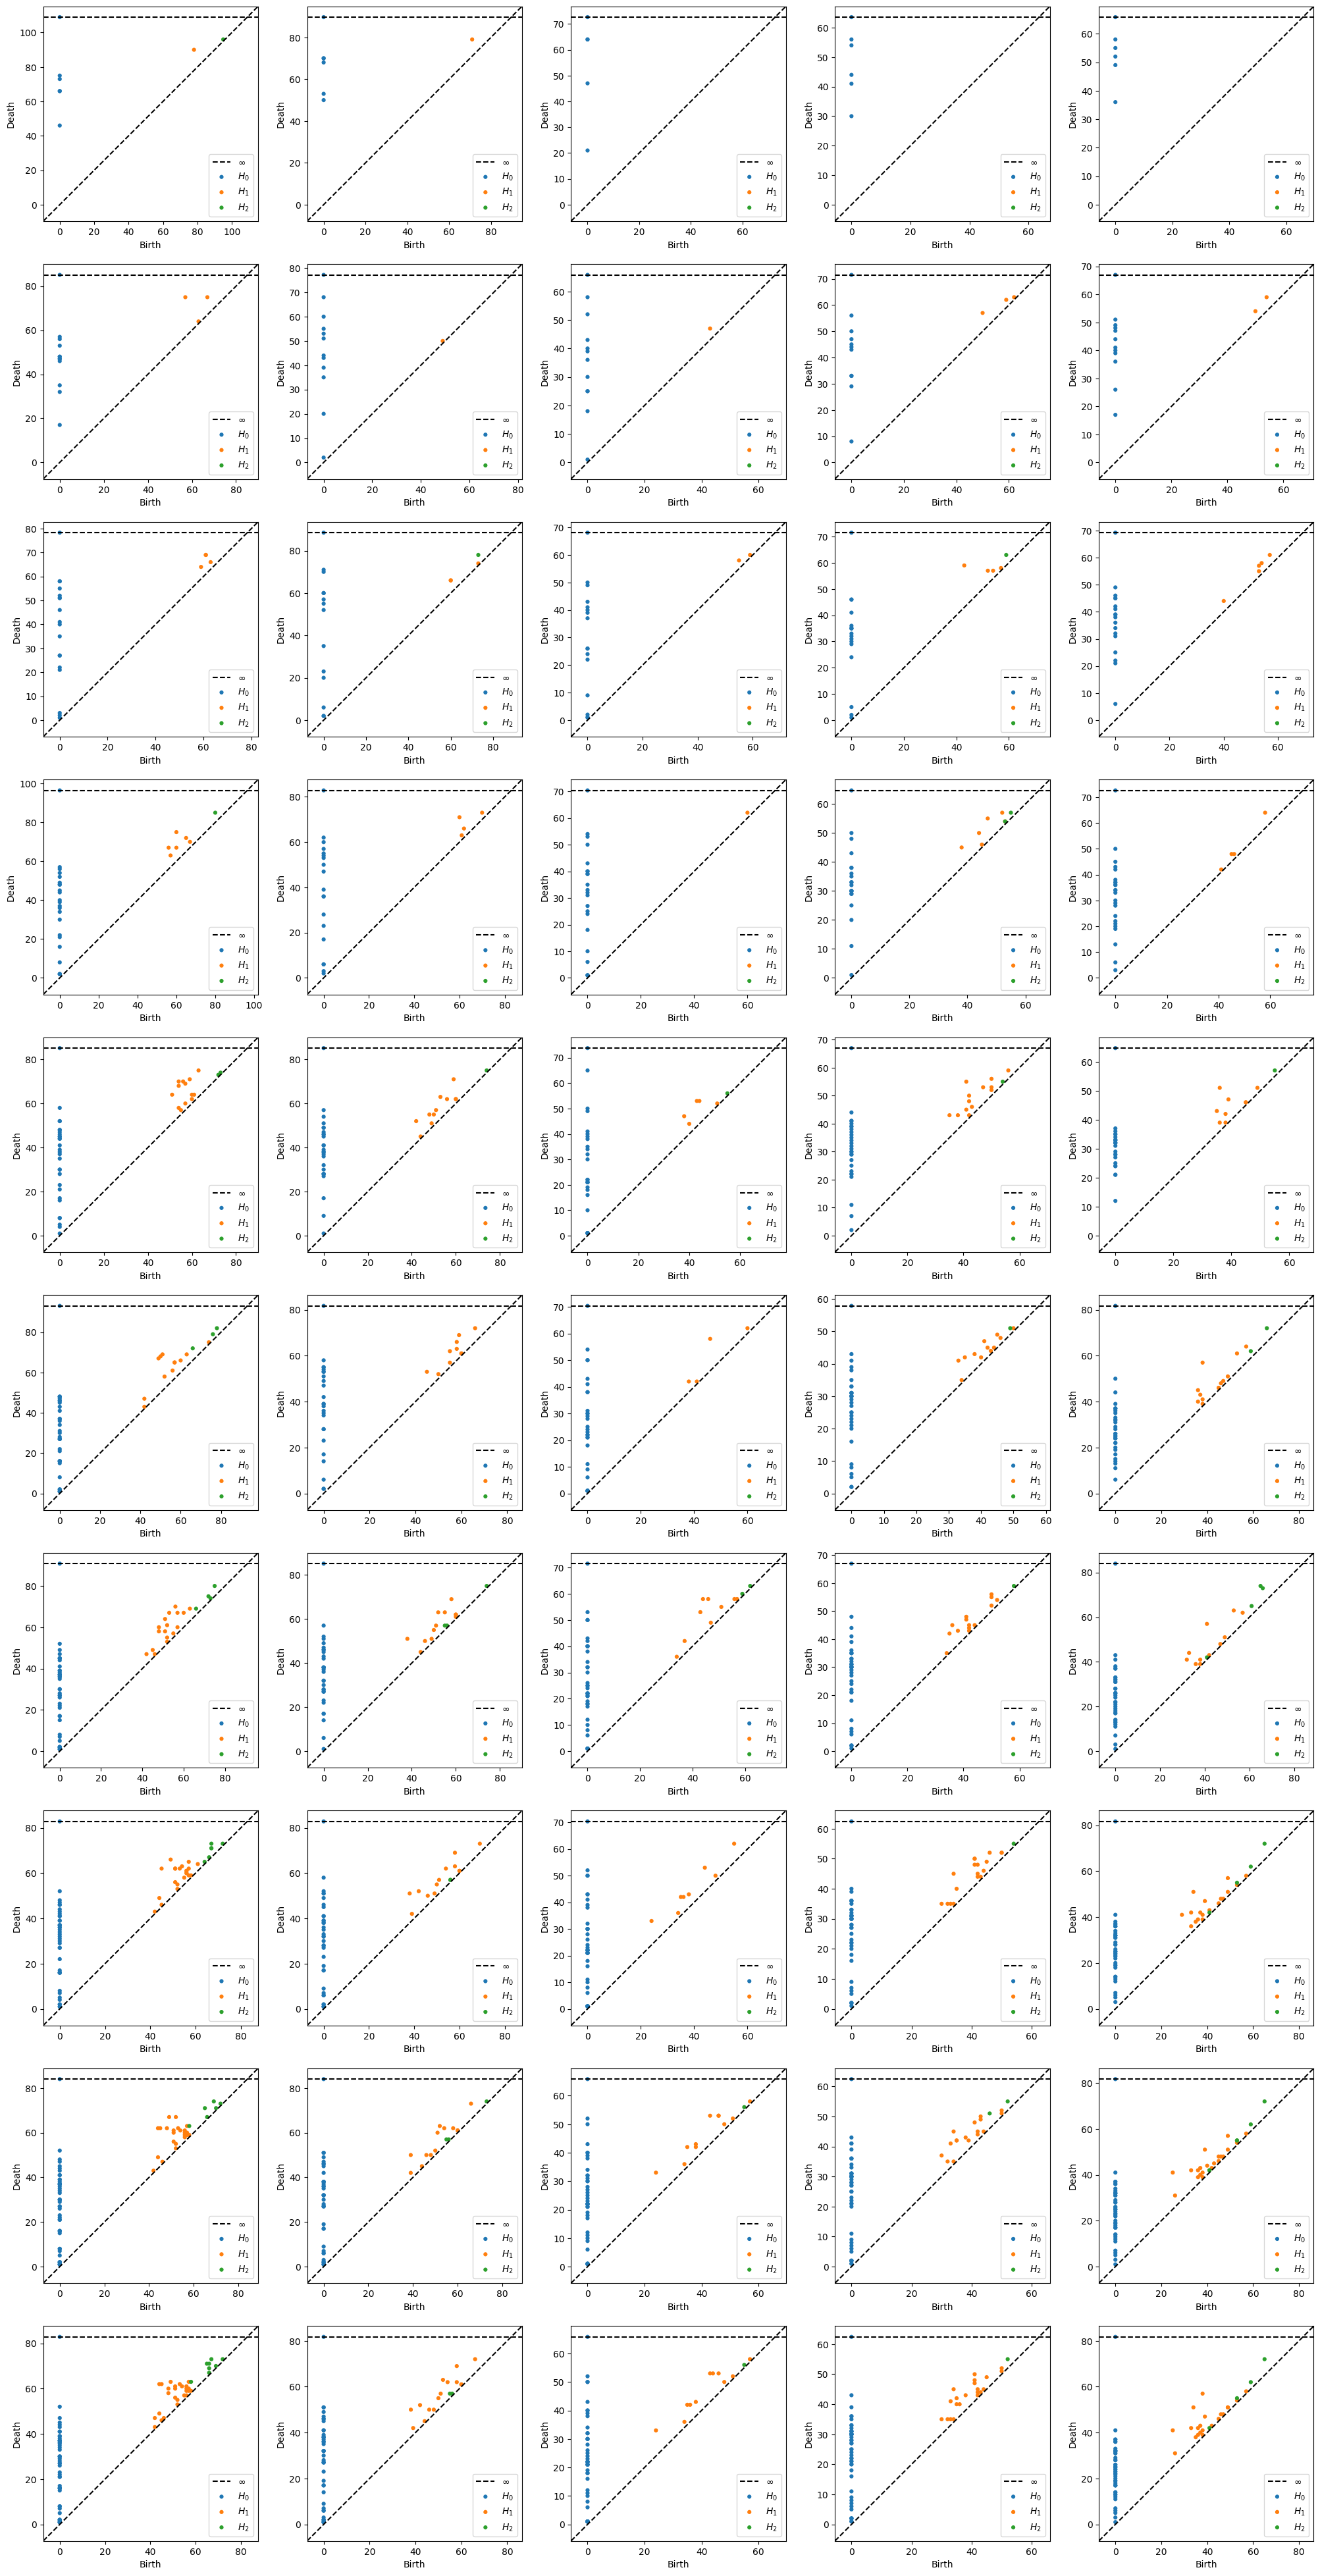

In [50]:
fig, axs = plt.subplots(nrows=10, ncols=5, figsize=(25,50))
# rips.plot(hom[0][0], show=True)

# Loop over the range of variances and simulations
for ratio in range(len(sparse_values)):  # Loop over the ratios
    for sim in range(targ.SIMULATIONS):  # Loop over the simulations
        rips.plot(sparsehom[sim][ratio], ax=axs[ratio, sim], show=False)  # Plot each hom[j][i] on the corresponding subplot


/Users/claire/Documents/PGC Bioinfo Training/Viral Recombination/Topo ARG/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/claire/Documents/PGC Bioinfo Training/Viral Recombination/Topo ARG/env/lib/python3.12/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/claire/Documents/PGC Bioinfo Training/Viral Recombination/Topo ARG/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4008: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claire/Documents/PGC Bioinfo Training/Viral Recombination/Topo ARG/env/lib/python3.12/site-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/claire/Documents/PGC Bioinfo Tr

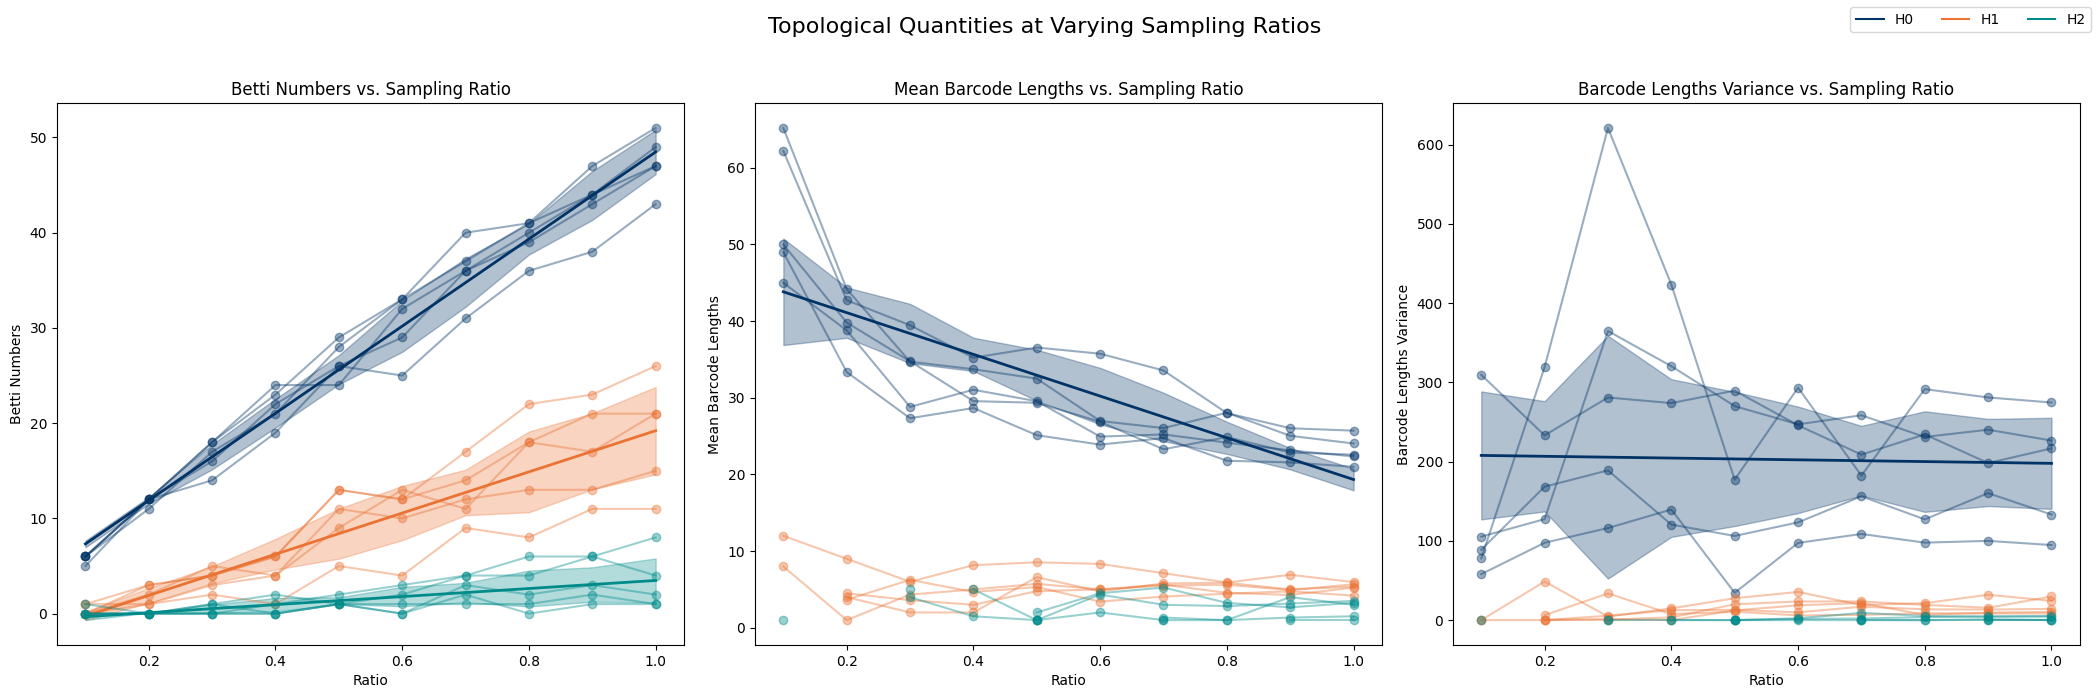

In [27]:
BETTIS_S, MEAN_BARCODE_LENGTHS_S, VAR_BARCODE_LENGTHS_S = get_topostats(targ, sparsehom)

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(21, 7))  # 1 row, 3 columns

# Plot the results in subplots
plot_lines(axs[0], targ, BETTIS_S, sparse_values, xlab='Ratio', ylab='Betti Numbers', main='Betti Numbers vs. Sampling Ratio')
plot_lines(axs[1], targ, MEAN_BARCODE_LENGTHS_S, sparse_values, xlab='Ratio', ylab='Mean Barcode Lengths', main='Mean Barcode Lengths vs. Sampling Ratio')
plot_lines(axs[2], targ, VAR_BARCODE_LENGTHS_S, sparse_values, xlab='Ratio', ylab='Barcode Lengths Variance', main='Barcode Lengths Variance vs. Sampling Ratio')

# Add a main title for the entire figure
fig.suptitle('Topological Quantities at Varying Sampling Ratios', fontsize=16)

# Create a single legend for the entire figure
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=3)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title
plt.show()


# RAW CODES / PIPELINE

In [ ]:
hom = []
# SETUP: hom[SIMULATION][VARIANCE]

for sim in stochmatrices:
    homologies = []

    # homologies of dimension (SIMULATIONS, STOCHMATRICES, MAXDIM+1, X)
    for var_idx in range(len(var_values)):
        homologies.append(rips.fit_transform(sim[var_idx], distance_matrix=True))

    hom.append(homologies)

# For testing purposes only
# hom # all 5 simulations, each of which has 21 lists of h0, h1, h2
# hom[0] # sim 1
# hom[0][0] # sim1: var = 0


In [ ]:
BETTIS = []
AVG_BARCODE_LENGTHS = []
VAR_BARCODE_LENGTHS = []


for sim_idx in range(params["SIMULATIONS"]):
    bettis_per_simulation = []
    avg_lengths_per_simulation = []
    var_lengths_per_simulation = []
    
    for var_idx in range(len(var_values)):
        homologies = hom[sim_idx][var_idx]  # Get homologies for this simulation and variance
        
        # Compute Betti numbers
        betti_numbers = targ.get_betti_numbers(homologies)
        bettis_per_simulation.append(betti_numbers)
        
        # Compute barcode lengths
        barcode_lens = targ.get_barcode_lengths(homologies)
        
        # Compute average and variance of barcode lengths
        avg_len, var_len = targ.get_barcode_length_statistics(barcode_lens)
        avg_lengths_per_simulation.append(avg_len)
        var_lengths_per_simulation.append(var_len)
    
    # Append the results for this simulation
    BETTIS.append(bettis_per_simulation)
    AVG_BARCODE_LENGTHS.append(avg_lengths_per_simulation)
    VAR_BARCODE_LENGTHS.append(var_lengths_per_simulation)


In [ ]:
# Define the variances
# variances = [round(x / 10, 2) for x in range(21)]

# Define colors for each homology dimension
colors = {
    0: '#013366',  # H0
    1: '#ea7334', # H1
    2: '#008b8b'    # H2
}

def add_trend_line_with_ci(ax, x, y, color, alpha=0.3):
    # Calculate the mean and standard deviation
    mean_y = np.mean(y, axis=0)
    std_y = np.std(y, axis=0)
    ci = 1.96 * (std_y / np.sqrt(len(y)))  # 95% confidence interval

    # Fit a polynomial of degree 1 (linear trend) to the data
    coefficients = np.polyfit(x, mean_y, 1)
    polynomial = np.poly1d(coefficients)
    trend_line = polynomial(x)

    # Plot the trend line
    ax.plot(x, trend_line, color=color, linestyle='-', linewidth=2)

    # Plot the confidence interval
    ax.fill_between(x, trend_line - ci, trend_line + ci, color=color, alpha=alpha)

def plot_betti_numbers(ax, BETTIS, var_values):
    for dim in range(targ.MAXDIM+1):  # H0, H1, H2
        all_sims = []
        for sim_idx in range(targ.SIMULATIONS):
            y = [BETTIS[sim_idx][var_idx][dim] for var_idx in range(len(var_values))]
            ax.plot(var_values, y, color=colors[dim], alpha=0.5, linestyle='-', marker='o')
            all_sims.append(y)
        
        # Calculate the mean and confidence interval for the trend line
        add_trend_line_with_ci(ax, var_values, np.array(all_sims), colors[dim])
        
        # Add a legend entry for each homology dimension
        ax.plot([], [], color=colors[dim], label=f'H{dim}')
    ax.set_xlabel('Variance')
    ax.set_ylabel('Betti Numbers')
    ax.set_title('Betti Numbers vs. Variance')
    # ax.grid(True)

def plot_avg_barcode_lengths(ax, AVG_BARCODE_LENGTHS, var_values):
    for dim in range(targ.MAXDIM+1):  # H0, H1, H2
        all_sims = []
        for sim_idx in range(params["SIMULATIONS"]):
            y = [AVG_BARCODE_LENGTHS[sim_idx][var_idx][dim] for var_idx in range(len(var_values))]
            ax.plot(var_values, y, color=colors[dim], alpha=0.5, linestyle='-', marker='o')
            all_sims.append(y)
        
        # Calculate the mean and confidence interval for the trend line
        add_trend_line_with_ci(ax, var_values, np.array(all_sims), colors[dim])
        
        # Add a legend entry for each homology dimension
        ax.plot([], [], color=colors[dim], label=f'H{dim}')
    ax.set_xlabel('Variance')
    ax.set_ylabel('Average Barcode Length')
    ax.set_title('Average Barcode Length vs. Variance')
    # ax.grid(True)

def plot_var_barcode_lengths(ax, VAR_BARCODE_LENGTHS, var_values):
    for dim in range(targ.MAXDIM+1):  # H0, H1, H2
        all_sims = []
        for sim_idx in range(params["SIMULATIONS"]):
            y = [VAR_BARCODE_LENGTHS[sim_idx][var_idx][dim] for var_idx in range(len(var_values))]
            ax.plot(var_values, y, color=colors[dim], alpha=0.5, linestyle='-', marker='o')
            all_sims.append(y)
        
        # Calculate the mean and confidence interval for the trend line
        add_trend_line_with_ci(ax, var_values, np.array(all_sims), colors[dim])
        
        # Add a legend entry for each homology dimension
        ax.plot([], [], color=colors[dim], label=f'H{dim}')
    ax.set_xlabel('Variance')
    ax.set_ylabel('Variance of Barcode Lengths')
    ax.set_title('Variance of Barcode Lengths vs. Variance')
    # ax.grid(True)

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(21, 7))  # 1 row, 3 columns

# Plot the results in subplots
plot_betti_numbers(axs[0], BETTIS_V, var_values)
plot_avg_barcode_lengths(axs[1], MEAN_BARCODE_LENGTHS_V, var_values)
plot_var_barcode_lengths(axs[2], VAR_BARCODE_LENGTHS_V, var_values)

# Add a main title for the entire figure
fig.suptitle('Topological Quantities at Varying Errors', fontsize=16)

# Create a single legend for the entire figure
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=3)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title
plt.show()


# OLD CODES

### Barcode Ensemble Diagrams

In [ ]:
fig = plt.figure(figsize=(6,12))
gs = fig.add_gridspec(nrows=3,hspace=0)
axs = gs.subplots(sharex=True, sharey=True)

colors=['blue', 'orange', 'green']
labels=['$H_0$','$H_1$', '$H_2$']

for i in range(0, betti_numbers.shape[0]):
    axs[i].set_ylabel(labels[i])
    axs[i].get_yaxis().set_ticks([])
    axs[i].label_outer()

    len_h = round(betti_numbers[i])
    for j in range(0, len_h):
        axs[i].plot(np.linspace(hom[i][j][0], hom[i][j][1], 2), [j, j], c=colors[i], linewidth=0.5)
    
axs[0].set_title("Barcode Ensemble Diagram")
axs[-1].set_xlabel("genetic distance")
plt.show()

### Varying variance plots

/Users/claire/Documents/PGC Bioinfo Training/Viral Recombination/Topo ARG/env/lib/python3.12/site-packages/numpy/_core/_methods.py:185: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


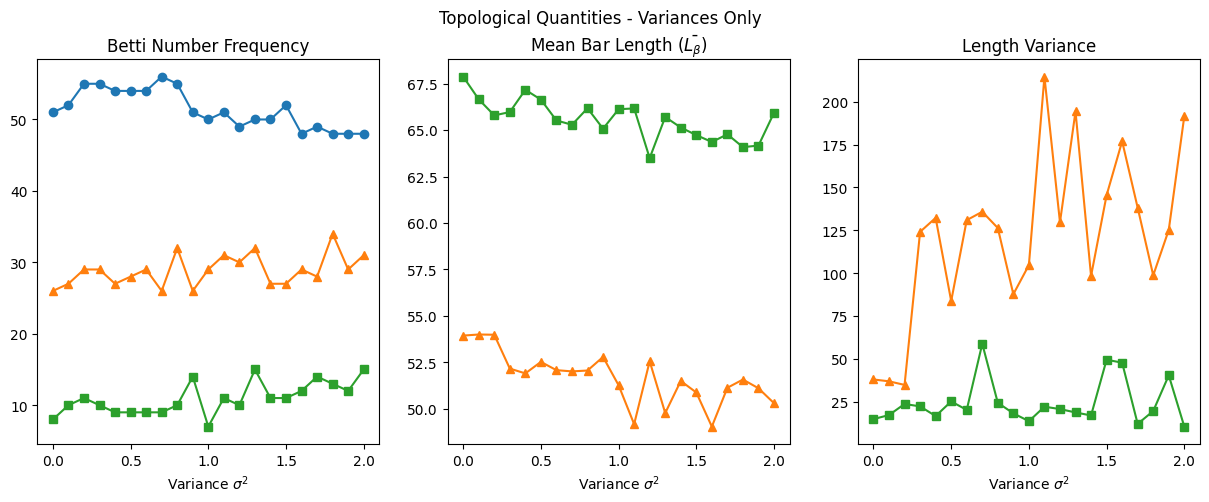

In [34]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

# Generate plot for Betti numbers of different variances
var_values = [round(x / 10, 2) for x in range(0,21)]

var_betti_numbers = np.empty((len(var_values), targ.MAXDIM + 1))
mean_barcode_lengths = np.empty((len(var_values),targ.MAXDIM + 1))
variance_barcode_lengths = np.empty((len(var_values), targ.MAXDIM + 1))

for i in range(0, len(var_values)):
    var_betti_numbers[i] = targ.get_betti_numbers(homologies[i])
    mean_barcode_lengths[i], variance_barcode_lengths[i] = targ.get_barcode_length_statistics(homologies[i])

# y1, y2, y3
var_betti_numbers = var_betti_numbers.T #transposed
mean_barcode_lengths = mean_barcode_lengths.T
variance_barcode_lengths = variance_barcode_lengths.T

fig.suptitle("Topological Quantities - Variances Only")

axs[0].plot(var_values, var_betti_numbers[0, :], label="Betti Number $\\beta_0$", marker="o")
axs[0].plot(var_values, var_betti_numbers[1, :], label="Betti Number $\\beta_1$", marker="^")
axs[0].plot(var_values, var_betti_numbers[2, :], label="Betti Number $\\beta_2$", marker="s")
axs[0].set_title("Betti Number Frequency")
axs[0].set(xlabel="Variance $\\sigma^2$")

axs[1].plot(var_values, mean_barcode_lengths[0, :], label="Mean Barcode Length $H_0$", marker="o")
axs[1].plot(var_values, mean_barcode_lengths[1, :], label="Mean Barcode Length $H_1$", marker="^")
axs[1].plot(var_values, mean_barcode_lengths[2, :], label="Mean Barcode Length $H_2$", marker="s")
axs[1].set_title("Mean Bar Length ($\\bar{L_\\beta}$)")
axs[1].set(xlabel="Variance $\\sigma^2$")

axs[2].plot(var_values, variance_barcode_lengths[0, :], label="Barcode Length Variance $H_0$", marker="o")
axs[2].plot(var_values, variance_barcode_lengths[1, :], label="Barcode Length Variance $H_1$", marker="^")
axs[2].plot(var_values, variance_barcode_lengths[2, :], label="Barcode Length Variance $H_2$", marker="s")
axs[2].set_title("Length Variance")
axs[2].set(xlabel="Variance $\\sigma^2$")

plt.show()

In [110]:
# homologies[VAR_LIST]

print("VARIANCE: ", var_betti_numbers)
print("BARCODE MEANS: ", mean_barcode_lengths)

# targ.get_barcode_lengths(homologies[0])

# var_betti_numbers[0]

VARIANCE:  [[51. 52. 55. 55. 54. 54. 54. 56. 55. 51. 50. 51. 49. 50. 50. 52. 48. 49.
  48. 48. 48.]
 [26. 27. 29. 29. 27. 28. 29. 26. 32. 26. 29. 31. 30. 32. 27. 27. 29. 28.
  34. 29. 31.]
 [ 8. 10. 11. 10.  9.  9.  9.  9. 10. 14.  7. 11. 10. 15. 11. 11. 12. 14.
  13. 12. 15.]]
BARCODE MEANS:  [[        inf         inf         inf         inf         inf         inf
          inf         inf         inf         inf         inf         inf
          inf         inf         inf         inf         inf         inf
          inf         inf         inf]
 [53.94230769 54.00109764 53.9888332  52.16754608 51.90848849 52.52672543
  52.08328546 52.01616964 52.06338783 52.79295322 51.27104087 49.17738782
  52.5620311  49.77479457 51.5008467  50.88153336 49.04510503 51.13535934
  51.57842782 51.10861366 50.3056456 ]
 [67.875      66.6541853  65.78966384 65.96850319 67.16729948 66.63765208
  65.5161669  65.2848515  66.17368793 65.07399804 66.11997386 66.16435762
  63.49107666 65.70233294 65.137497

[[array([[ 0.,  1.],
         [ 0.,  1.],
         [ 0.,  1.],
         [ 0.,  1.],
         [ 0.,  1.],
         [ 0.,  2.],
         [ 0.,  2.],
         [ 0.,  2.],
         [ 0.,  2.],
         [ 0.,  5.],
         [ 0.,  7.],
         [ 0.,  8.],
         [ 0.,  8.],
         [ 0., 15.],
         [ 0., 16.],
         [ 0., 16.],
         [ 0., 16.],
         [ 0., 16.],
         [ 0., 17.],
         [ 0., 21.],
         [ 0., 21.],
         [ 0., 22.],
         [ 0., 23.],
         [ 0., 26.],
         [ 0., 27.],
         [ 0., 27.],
         [ 0., 28.],
         [ 0., 29.],
         [ 0., 30.],
         [ 0., 30.],
         [ 0., 30.],
         [ 0., 33.],
         [ 0., 34.],
         [ 0., 35.],
         [ 0., 36.],
         [ 0., 36.],
         [ 0., 37.],
         [ 0., 37.],
         [ 0., 37.],
         [ 0., 37.],
         [ 0., 38.],
         [ 0., 39.],
         [ 0., 39.],
         [ 0., 41.],
         [ 0., 41.],
         [ 0., 43.],
         [ 0., 44.],
         [ 0.

## With Sparsity

In [ ]:
# (SIMULATIONS, SPARSITY, SAMPLES, SEGSITES)
sparse_group_samples = targ.sparsity_sampling(group)

In [ ]:
sparsity_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
sparse_hdmatrices = []

for i in range(0, len(sparsity_list)):
    targ.SAMPLES = int(targ.SAMPLES * sparsity_list[i])
    sparse_hdmatrices.append(targ.get_hdmatrices([sparse_group_samples[i]]))
    targ.SAMPLES = params["SAMPLES"]

OverflowError: Python int too large to convert to C long

In [ ]:
sparse_homologies = []
for sp in sparse_hdmatrices:
    sparse_homologies.append(rips.fit_transform(sp[0], distance_matrix=True))

sp_hom = sparse_homologies[3]

IndexError: list index out of range

In [ ]:
sparse_betti_numbers = targ.get_betti_numbers(sp_hom)

# Compute Barcode Lengths
sparse_barcode_lens = targ.get_barcode_lengths(sp_hom)

# Compute Barcode Means and Variances
sparse_barcode_means, sparse_barcode_vars = targ.get_barcode_length_statistics(sp_hom)

NameError: name 'sp_hom' is not defined

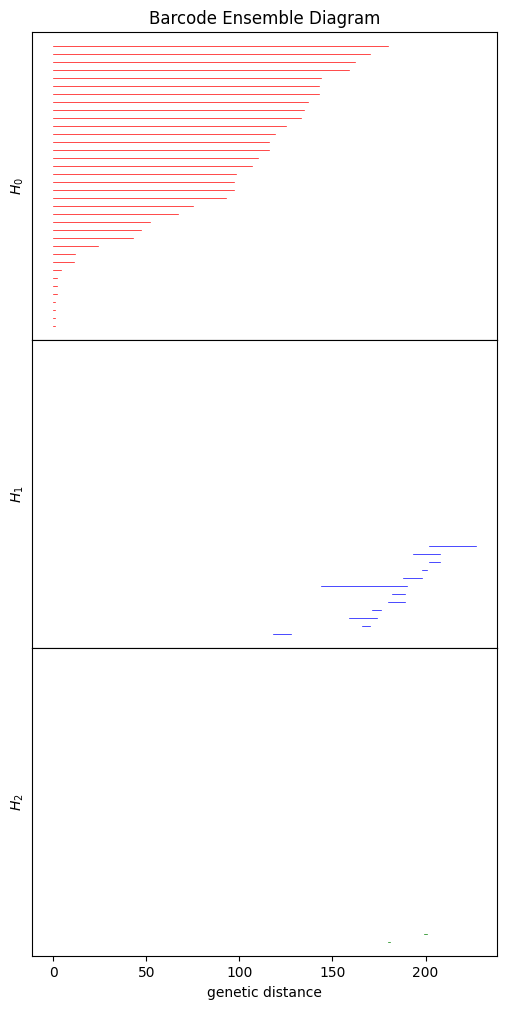

In [ ]:
fig = plt.figure(figsize=(6,12))
gs = fig.add_gridspec(nrows=3,hspace=0)
axs = gs.subplots(sharex=True, sharey=True)

colors=['r', 'b', 'g']
labels=['$H_0$','$H_1$', '$H_2$']

for i in range(0, sparse_betti_numbers.shape[0]):
    axs[i].set_ylabel(labels[i])
    axs[i].get_yaxis().set_ticks([])
    axs[i].label_outer()

    len_h = round(sparse_betti_numbers[i])
    for j in range(0, len_h):
        axs[i].plot(np.linspace(sp_hom[i][j][0], sp_hom[i][j][1], 2), [j, j], c=colors[i], linewidth=0.5)
    
axs[0].set_title("Barcode Ensemble Diagram")
axs[-1].set_xlabel("genetic distance")
plt.show()

c:\AnacondaDestination\envs\targ\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\AnacondaDestination\envs\targ\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\AnacondaDestination\envs\targ\Lib\site-packages\numpy\_core\fromnumeric.py:4008: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\AnacondaDestination\envs\targ\Lib\site-packages\numpy\_core\_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\AnacondaDestination\envs\targ\Lib\site-packages\numpy\_core\_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


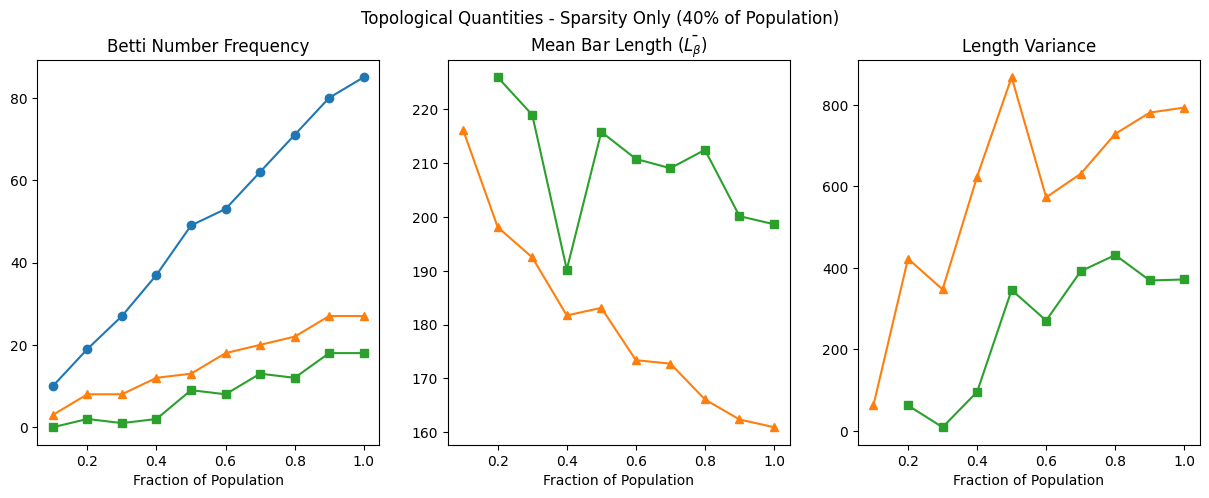

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

# Generate plot for Betti numbers of different variances
sparse_var_betti_numbers = np.empty((len(sparsity_list), targ.MAXDIM + 1))
sparse_mean_barcode_lengths = np.empty((len(sparsity_list),targ.MAXDIM + 1))
sparse_variance_barcode_lengths = np.empty((len(sparsity_list), targ.MAXDIM + 1))

for i in range(0, len(sparsity_list)):
    sparse_var_betti_numbers[i] = targ.get_betti_numbers(sparse_homologies[i])
    sparse_mean_barcode_lengths[i], sparse_variance_barcode_lengths[i] = targ.get_barcode_length_statistics(sparse_homologies[i])

# y1, y2, y3
sparse_var_betti_numbers = sparse_var_betti_numbers.T
sparse_mean_barcode_lengths = sparse_mean_barcode_lengths.T
sparse_variance_barcode_lengths = sparse_variance_barcode_lengths.T

fig.suptitle("Topological Quantities - Sparsity Only (40% of Population)")

axs[0].plot(sparsity_list, sparse_var_betti_numbers[0, :], label="Betti Number $\\beta_0$", marker="o")
axs[0].plot(sparsity_list, sparse_var_betti_numbers[1, :], label="Betti Number $\\beta_1$", marker="^")
axs[0].plot(sparsity_list, sparse_var_betti_numbers[2, :], label="Betti Number $\\beta_2$", marker="s")
axs[0].set_title("Betti Number Frequency")
axs[0].set(xlabel="Fraction of Population")

axs[1].plot(sparsity_list, sparse_mean_barcode_lengths[0, :], label="Mean Barcode Length $H_0$", marker="o")
axs[1].plot(sparsity_list, sparse_mean_barcode_lengths[1, :], label="Mean Barcode Length $H_1$", marker="^")
axs[1].plot(sparsity_list, sparse_mean_barcode_lengths[2, :], label="Mean Barcode Length $H_2$", marker="s")
axs[1].set_title("Mean Bar Length ($\\bar{L_\\beta}$)")
axs[1].set(xlabel="Fraction of Population")

axs[2].plot(sparsity_list, sparse_variance_barcode_lengths[0, :], label="Barcode Length Variance $H_0$", marker="o")
axs[2].plot(sparsity_list, sparse_variance_barcode_lengths[1, :], label="Barcode Length Variance $H_1$", marker="^")
axs[2].plot(sparsity_list, sparse_variance_barcode_lengths[2, :], label="Barcode Length Variance $H_2$", marker="s")
axs[2].set_title("Length Variance")
axs[2].set(xlabel="Fraction of Population")

plt.show()

In [ ]:
sparse_variance_barcode_lengths

array([[         nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan],
       [ 63.13888889, 422.734375  , 347.125     , 624.03993056,
        868.02514793, 573.18209877, 630.9875    , 728.99173554,
        781.15912209, 793.55006859],
       [         nan,  62.5       ,   9.        ,  95.6875    ,
        345.80555556, 270.90234375, 391.84023669, 431.66666667,
        369.25      , 371.61111111]])

## Cocycles

In [ ]:
# Produces cocycles
result = ripser(stochmatrices[0][0], maxdim=targ.MAXDIM, do_cocycles=True, distance_matrix=True)
"""
(some) Parameters of variable 'result':

"dgms" - diagrams; identical to the contents of homologies[0]
"dperm2all" - hamming distance matrix; identical to the HD matrix in stochmatrices[0][0]
"cocycles" - cocycles; suprisingly not identical to the other set of cocycles in rips
"""
hd_mat = result["dperm2all"]
cocycles = result["cocycles"]
diagrams = result["dgms"]

# Is the cocycles of rips equal to the cocycles of result? Ans: False
print(np.array_equal(rips.cocycles_[2], result["cocycles"][2]))

False


In [ ]:
cocycles[1]

[array([[95, 77,  1],
        [88, 77,  1],
        [77, 68,  1],
        [93, 77,  1]]),
 array([[78, 54,  1],
        [54, 11,  1]]),
 array([[87, 50,  1],
        [97, 87,  1],
        [87, 69,  1],
        [87, 25,  1],
        [87, 66,  1],
        [87, 32,  1],
        [87, 27,  1],
        [87, 23,  1]]),
 array([[61, 54,  1],
        [61, 29,  1]]),
 array([[70, 22,  1]]),
 array([[41, 27,  1],
        [41, 23,  1],
        [33, 27,  1],
        [33, 23,  1],
        [41,  5,  1],
        [33,  5,  1]]),
 array([[19,  6,  1]]),
 array([[84,  0,  1],
        [17,  0,  1],
        [ 9,  0,  1],
        [96,  0,  1],
        [96, 80,  1],
        [86,  0,  1],
        [31,  0,  1],
        [96,  7,  1],
        [98, 96,  1],
        [96, 72,  1]]),
 array([[92, 90,  1],
        [90, 49,  1],
        [90, 50,  1],
        [94, 90,  1],
        [94, 36,  1]]),
 array([[29, 13,  1],
        [29,  4,  1]]),
 array([[97, 56,  1],
        [56, 35,  1],
        [56, 25,  1],
        [97,

In [ ]:
def drawLineColored(X, C):
    for i in range(X.shape[0]-1):
        plt.plot(X[i:i+2, 0], X[i:i+2, 1], c=C[i, :], linewidth = 3)

def plotCocycle2D(D, X, cocycle, thresh):
    """
    Given a 2D point cloud X, display a cocycle projected
    onto edges under a given threshold "thresh"
    """
    #Plot all edges under the threshold
    N = X.shape[0]
    t = np.linspace(0, 1, 10)
    c = plt.get_cmap('Greys')
    C = c(np.array(np.round(np.linspace(0, 255, len(t))), dtype=np.int32))
    C = C[:, 0:3]

    for i in range(N):
        for j in range(N):
            if D[i, j] <= thresh:
                Y = np.zeros((len(t), 2))
                Y[:, 0] = X[i, 0] + t*(X[j, 0] - X[i, 0])
                Y[:, 1] = X[i, 1] + t*(X[j, 1] - X[i, 1])
                drawLineColored(Y, C)
    #Plot cocycle projected to edges under the chosen threshold
    for k in range(cocycle.shape[0]):
        [i, j, val] = cocycle[k, :]
        if D[i, j] <= thresh:
            [i, j] = [min(i, j), max(i, j)]
            a = 0.5*(X[i, :] + X[j, :])
            plt.text(a[0], a[1], '%g'%val, color='b')
    #Plot vertex labels
    for i in range(N):
        plt.text(X[i, 0], X[i, 1], '%i'%i, color='r')
    plt.axis('equal')

In [ ]:
from persim import plot_diagrams

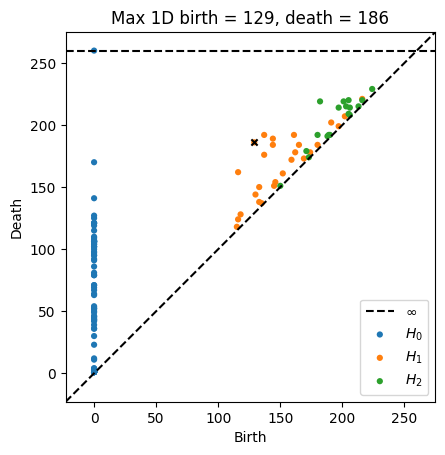

In [ ]:
dgm1 = diagrams[1]
idx = np.argmax(dgm1[:, 1] - dgm1[:, 0])
plot_diagrams(diagrams, show = False)
plt.scatter(dgm1[idx, 0], dgm1[idx, 1], 20, 'k', 'x')
plt.title("Max 1D birth = %.3g, death = %.3g"%(dgm1[idx, 0], dgm1[idx, 1]))
plt.show()

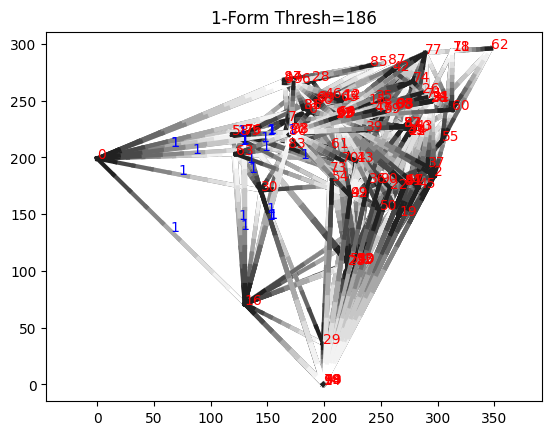

In [ ]:
cocycle = cocycles[1][idx]
thresh = dgm1[idx, 1] #Project cocycle onto edges less than or equal to death time

# Plot the hamming distance...twice???
plotCocycle2D(hd_mat, stochmatrices[0][0], cocycle, thresh)
plt.title("1-Form Thresh=%g"%thresh)
plt.show()